# MODELADO: Regresión sobre la valoracion del 2022

In [473]:
# Generales y preprocesamiento
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

# Preparación para modelos
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from scipy.special import inv_boxcox
from scipy.stats import boxcox
from hyperopt import hp,fmin,tpe,STATUS_OK,Trials, space_eval

# Modelos
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, TweedieRegressor, Lasso, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import  DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor,StackingRegressor

# Validación y guardado de modelos
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
import pickle

import matplotlib.pyplot as plt

# funciones
import modelado.funciones_modelado as fmod

import warnings


from sklearn.compose import ColumnTransformer

In [474]:
# Carga de datos limpios
path_limpios = 'Datos/Limpios/'

try:
    df_regr = fmod.carga_datos_limpios('df_regr')
    df_regr_prefusion = fmod.carga_datos_limpios('df_regr_prefusion')
except:
    df_regr = fmod.carga_datos_limpios('df_regr', path_limpios)
    df_regr_prefusion = fmod.carga_datos_limpios('df_regr_prefusion', path_limpios)

In [475]:
df_regr.set_index("Codigo_NIF", inplace=True)

In [476]:
df_regr=df_regr.drop(['index', 'ownerships'], axis=1)

In [477]:
df_regr_prefusion = df_regr_prefusion.drop(columns=['first_funding_date', 'last_funding_date', 'Free capital mil EUR'])

In [478]:
df_regr.shape

(60, 64)

In [479]:
df_regr_prefusion.shape

(120, 66)

In [480]:
RANDOM_STATE = 42

## 1. Preprocesamiento

### 1.1 Limpieza de variables

In [481]:
df_regr=fmod.quitar_variables_ident(df_regr)
df_regr_prefusion=fmod.quitar_variables_ident(df_regr_prefusion)

### 1.2 Label Encoding de las categóricas

In [482]:
df_regr = fmod.label_encoder_categoricas(df_regr)
df_regr_prefusion=fmod.label_encoder_categoricas(df_regr_prefusion)

### 1.3 Transformar df

In [483]:
df_regr=np.log(df_regr+1)
df_regr_prefusion=np.log(df_regr_prefusion+1)

In [484]:
df_regr=df_regr.dropna(axis=1)
df_regr_prefusion=df_regr_prefusion.dropna(axis=1)

### 1.3 Selección de variables

* Correlacion

In [485]:
# Observamos las correlaciones con la variable objetivo

correlaciones=df_regr.corr()
correlaciones.loc[:,"valuation_2022"].sort_values(ascending=False)

# no hay tan buena correlación

valuation_2022                                                1.000000
Activo circulante mil EUR                                     0.704769
Tesorería mil EUR                                             0.700543
Total activo mil EUR                                          0.674296
Total pasivo y capital propio mil EUR                         0.674296
Inmovilizado mil EUR                                          0.590409
Pasivo líquido mil EUR                                        0.572060
Existencias mil EUR                                           0.546402
total_funding                                                 0.522243
Pasivo fijo mil EUR                                           0.468260
Acreedores comerciales mil EUR                                0.430842
last_funding                                                  0.411438
Dotaciones para amortiz. de inmovil. mil EUR                  0.396312
total_rounds                                                  0.354861
dias_o

In [486]:
# Observamos las correlaciones con la variable objetivo

correlaciones=df_regr_prefusion.corr()
correlaciones=correlaciones.loc[:,"valuation_2022"].sort_values(ascending=False)
correlaciones
# no hay tan buena correlación

valuation_2022                                                1.000000e+00
Activo circulante mil EUR                                     6.875414e-01
Tesorería mil EUR                                             6.477650e-01
Total activo mil EUR                                          6.443259e-01
Total pasivo y capital propio mil EUR                         6.443259e-01
Inmovilizado mil EUR                                          5.489783e-01
total_funding                                                 5.222434e-01
Pasivo líquido mil EUR                                        5.200960e-01
Existencias mil EUR                                           5.123051e-01
Pasivo fijo mil EUR                                           4.648514e-01
last_funding                                                  4.114381e-01
Acreedores comerciales mil EUR                                3.843625e-01
Dotaciones para amortiz. de inmovil. mil EUR                  3.806726e-01
total_rounds             

In [487]:
df_regr_cor=fmod.vars_correlacion_reg(df_regr, 0.15)
df_regr_pref_cor=fmod.vars_correlacion_reg(df_regr_prefusion, 0.2)

Hay 27 variables con una correlacion mayor a 0.15
Hay 22 variables con una correlacion mayor a 0.2


* Feature importance Random Forest

{'Capital social mil EUR': 0.03, 'Free capital mil EUR': 0.0, 'total_funding': 0.03, 'last_funding': 0.01, 'last_round': 0.0, 'total_rounds': 0.03, 'b2b_b2c': 0.0, 'revenue_models': 0.0, 'growth_stage': 0.0, 'company_status': 0.0, 'Número empleados': 0.01, 'Inmovilizado mil EUR': 0.04, 'Activo circulante mil EUR': 0.27, 'Total activo mil EUR': 0.05, 'Pasivo fijo mil EUR': 0.02, 'Pasivo líquido mil EUR': 0.0, 'Total pasivo y capital propio mil EUR': 0.05, 'Costes de los trabajadores / Ingresos de explotación (%) %': 0.01, 'Tesorería mil EUR': 0.16, 'Período de cobro (días) días': 0.01, 'Endeudamiento (%) %': 0.01, 'Ratio de liquidez %': 0.01, 'Ratio de solvencia %': 0.01, 'Rotación de activos netos %': 0.0, 'Rotación de las existencias %': 0.02, 'Liquidez general %': 0.0, 'Ratios de autonomía financiera a medio y largo plazo %': 0.05, 'Dotaciones para amortiz. de inmovil. mil EUR': 0.01, 'Deudas financieras mil EUR': 0.01, 'Importe neto Cifra de Ventas mil EUR': 0.0, 'Existencias mil EU

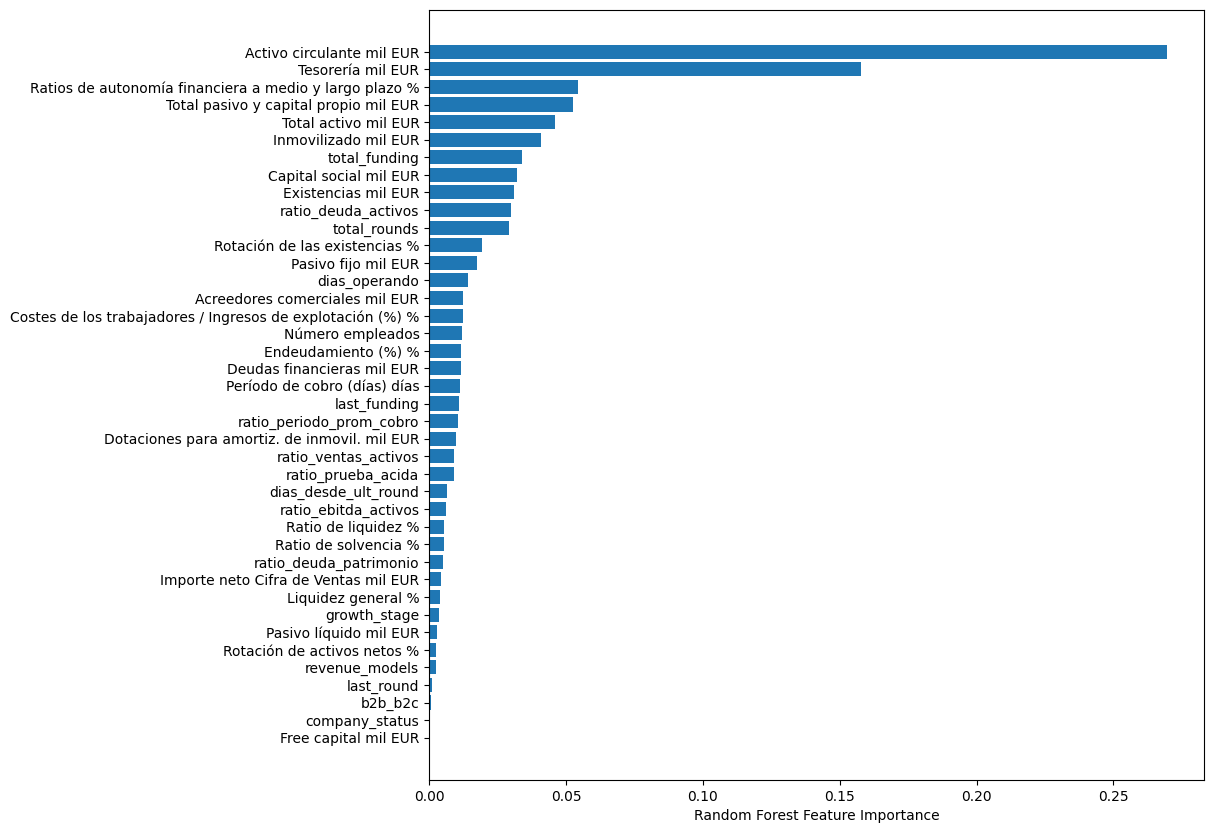

In [488]:
df_regr_imp=fmod.vars_importantes_rf_reg(df_regr,0.01 )

{'Capital social mil EUR': 0.03, 'Porcentaje_adquisicion_cat': 0.0, 'total_funding': 0.04, 'last_funding': 0.02, 'last_round': 0.0, 'total_rounds': 0.02, 'ownerships': 0.03, 'b2b_b2c': 0.0, 'revenue_models': 0.0, 'growth_stage': 0.0, 'company_status': 0.0, 'year': 0.0, 'Número empleados': 0.03, 'Inmovilizado mil EUR': 0.03, 'Activo circulante mil EUR': 0.42, 'Total activo mil EUR': 0.02, 'Pasivo fijo mil EUR': 0.02, 'Pasivo líquido mil EUR': 0.0, 'Total pasivo y capital propio mil EUR': 0.02, 'Costes de los trabajadores / Ingresos de explotación (%) %': 0.01, 'Tesorería mil EUR': 0.09, 'Período de cobro (días) días': 0.01, 'Endeudamiento (%) %': 0.01, 'Ratio de liquidez %': 0.0, 'Ratio de solvencia %': 0.01, 'Rotación de activos netos %': 0.0, 'Rotación de las existencias %': 0.01, 'Liquidez general %': 0.0, 'Ratios de autonomía financiera a medio y largo plazo %': 0.04, 'Dotaciones para amortiz. de inmovil. mil EUR': 0.01, 'Deudas financieras mil EUR': 0.02, 'Importe neto Cifra de Ven

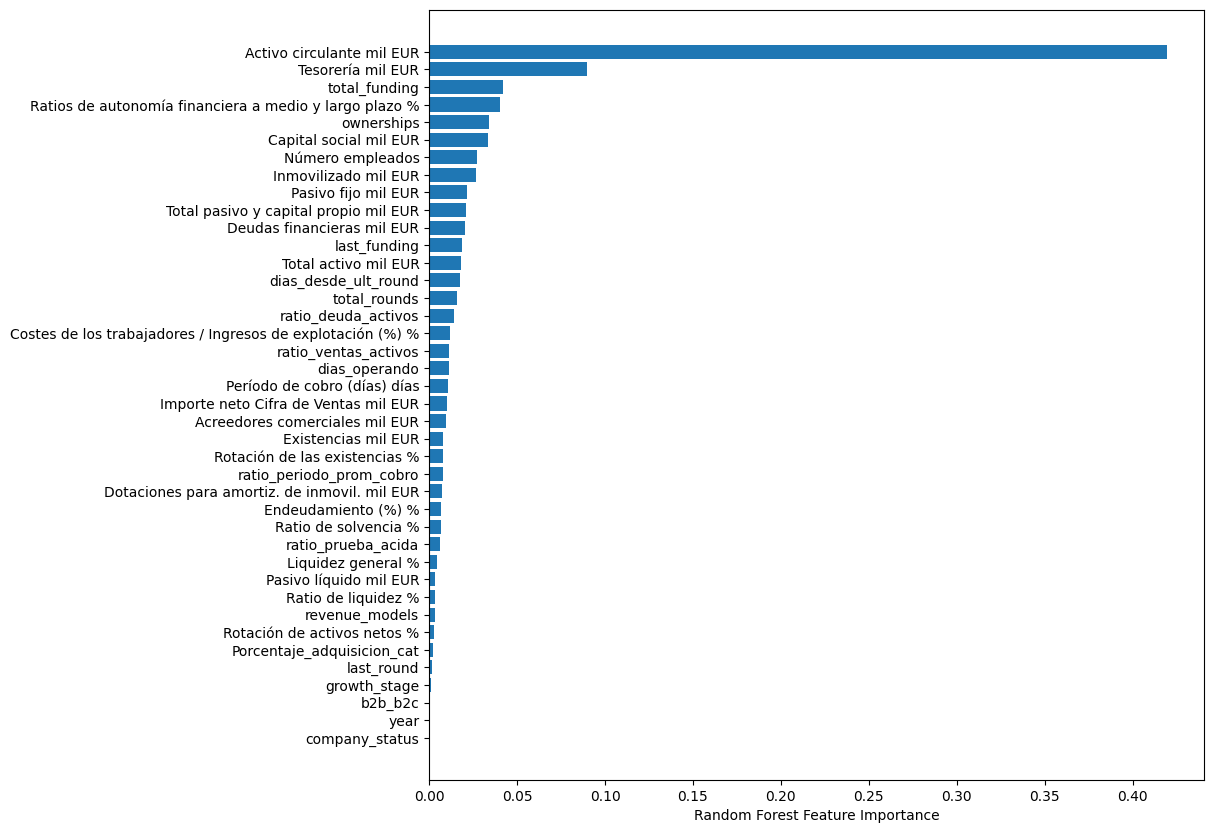

In [489]:
df_regr_pref_imp=fmod.vars_importantes_rf_reg(df_regr_prefusion,0.02 )

* Variables ratios

In [490]:
df_regr_ratio = df_regr.filter(regex='^(ratio|valuation)')
print(f'Contiene {df_regr_ratio.shape[1]} columnas')
df_regr_pref_ratio = df_regr_prefusion.filter(regex='^(ratio|valuation)')
print(f'Contiene {df_regr_pref_ratio.shape[1]} columnas')


Contiene 7 columnas
Contiene 5 columnas


### 1.4 Escalado

In [491]:


df_regr_cor_esc, df_regr_cor_nor = fmod.normalizacion_reg(df_regr_cor)
df_regr_pref_cor_esc, df_regr_pref_cor_nor = fmod.normalizacion_reg(df_regr_pref_cor)
df_regr_imp_esc, df_regr_imp_nor  = fmod.normalizacion_reg(df_regr_imp)
df_regr_pref_imp_esc, df_regr_pref_imp_nor = fmod.normalizacion_reg(df_regr_pref_imp)
df_regr_ratio_esc, df_regr_ratio_nor = fmod.normalizacion_reg(df_regr_ratio)
df_regr_pref_ratio_esc, df_regr_pref_ratio_nor = fmod.normalizacion_reg(df_regr_pref_ratio)

df_lista=[df_regr_cor_esc, df_regr_cor_nor,df_regr_pref_cor_esc, df_regr_pref_cor_nor,df_regr_imp_esc, df_regr_imp_nor,df_regr_pref_imp_esc, df_regr_pref_imp_nor,
          df_regr_ratio_esc, df_regr_ratio_nor,df_regr_pref_ratio_esc, df_regr_pref_ratio_nor]
df_lista_nombre=['df_regr_cor_esc', 'df_regr_cor_nor','df_regr_pref_cor_esc', 'df_regr_pref_cor_nor','df_regr_imp_esc', 'df_regr_imp_nor','df_regr_pref_imp_esc', 'df_regr_pref_imp_nor',
           'df_regr_ratio_esc', 'df_regr_ratio_nor','df_regr_pref_ratio_esc', 'df_regr_pref_ratio_nor']

In [492]:
df_lista_original=[df_regr_cor,df_regr_pref_cor, df_regr_imp, df_regr_pref_imp, df_regr_ratio, df_regr_pref_ratio ]
df_original_nombres=['df_regr_cor','df_regr_pref_cor', 'df_regr_imp', 'df_regr_pref_imp', 'df_regr_ratio', 'df_regr_pref_ratio']

## 2. Modelos simples

In [493]:
i=0
for df in df_lista_original:
    print(df_original_nombres[i])
    fmod.probar_dataset_reg(df)
    i+=1

df_regr_cor
            
RandomForestRegressor
MSE:  1.830672920471356
R2:  0.34797356030318416
RMSE:  1.3530236215496594
MAPE: 1.5016723862645514


LinearRegression
MSE:  3.442615973071554
R2:  -0.22614838022910266
RMSE:  1.8554287841551758
MAPE: 2.0522382216931265


SVR
MSE:  1.7758449645400993
R2:  0.36750150355396805
RMSE:  1.332608331258701
MAPE: 1.4960815482499046


KNeighborsRegressor
MSE:  2.300206783970887
R2:  0.18074079583105573
RMSE:  1.516643261934357
MAPE: 1.9777788613022336


DecisionTreeRegressor
MSE:  2.3856998469526824
R2:  0.15029093400623406
RMSE:  1.544571088345461
MAPE: 0.9398175541368973


TweedieRegressor
MSE:  1.72862656402651
R2:  0.3843191694683832
RMSE:  1.3147724381148662
MAPE: 1.607661042159104


Mejor modelo: DecisionTreeRegressor(random_state=42) , que tiene un MAPE de: 0.9398175541368973
              
df_regr_pref_cor
            
RandomForestRegressor
MSE:  0.8311657552532004
R2:  0.5912643819806327
RMSE:  0.9116829247349104
MAPE: 0.6964871504745404



In [494]:
i=0
for df in df_lista:
    print(df_lista_nombre[i])
    fmod.probar_dataset_reg(df)
    i+=1

df_regr_cor_esc
            
RandomForestRegressor
MSE:  1.830672920471356
R2:  0.34797356030318416
RMSE:  1.3530236215496594
MAPE: 1.5016723862645514


LinearRegression
MSE:  3.442612179764201
R2:  -0.2261470291758041
RMSE:  1.8554277619363684
MAPE: 2.0522422846653945


SVR
MSE:  2.259568898958872
R2:  0.19521469511961376
RMSE:  1.503186248925552
MAPE: 1.7284396593532545


KNeighborsRegressor
MSE:  2.0159533711297866
R2:  0.2819826608708964
RMSE:  1.4198427276039367
MAPE: 1.6195867200193603


DecisionTreeRegressor
MSE:  2.3856998469526824
R2:  0.15029093400623406
RMSE:  1.544571088345461
MAPE: 0.9398175541368973


TweedieRegressor
MSE:  1.7717893945408523
R2:  0.36894596631844123
RMSE:  1.33108579533434
MAPE: 1.5973041027351063


Mejor modelo: DecisionTreeRegressor(random_state=42) , que tiene un MAPE de: 0.9398175541368973
              
df_regr_cor_nor
            
RandomForestRegressor
MSE:  1.830672920471356
R2:  0.34797356030318416
RMSE:  1.3530236215496594
MAPE: 1.50167238626455

In [495]:
print(f'El mejor dataset para regresión de los probados es: {"df_regr_imp"}')

El mejor dataset para regresión de los probados es: df_regr_imp


In [496]:
df_regr_imp_nor.to_csv("datos_flask_regresion.csv", index=False)

In [497]:
independinetes=df_regr_imp.drop('valuation_2022', axis=1)
target=df_regr_imp['valuation_2022']

X_train, X_test, y_train, y_test = train_test_split(independinetes, target, test_size=0.2, random_state=42)

# transformamos y_train
prin=y_train

y_train, lambdas = boxcox(y_train)


## AutoML

In [498]:
from sklearn.model_selection import RepeatedStratifiedKFold
from tpot import TPOTRegressor


tpot = TPOTRegressor(generations=10, population_size=50, verbosity=2,random_state=RANDOM_STATE, scoring="r2")
tpot.fit(X_train, y_train)



                                                                             
Generation 1 - Current best internal CV score: 0.5592092278227965
                                                                              
Generation 2 - Current best internal CV score: 0.5592092278227965
                                                                              
Generation 3 - Current best internal CV score: 0.5592092278227965
                                                                              
Generation 4 - Current best internal CV score: 0.5592092278227965
                                                                              
Generation 5 - Current best internal CV score: 0.5592092278227965
                                                                              
Generation 6 - Current best internal CV score: 0.5592092278227965
                                                                              
Generation 7 - Current best internal CV score: 0.559

TPOTRegressor(generations=10, population_size=50, random_state=42, scoring='r2',
              verbosity=2)

In [499]:
fmod.prediccion_regr(tpot, X_test, y_test, lambdas)

R2: 0.46 
 MAPE: 1.4463 
 MAE : 0.97 
 RMSE : 1.2266


## 3. Grid search del mejor dataframe

In [500]:
model_list=[KNeighborsRegressor(), DecisionTreeRegressor(random_state=0), SVR(), TweedieRegressor(), LinearRegression()]

model_hyperparameters={"kn":{
    "n_neighbors": [3,5,7],
    "leaf_size": [15,30],
    'weights':['uniform', 'distance']
},
"tree_reg":{
    'criterion':['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    "max_depth":[None, 3, 5,10],
    'min_samples_split':[0,2,5,10]
},
"svr":{
    'kernel':['linear', 'rbf'],
    "C":[1,3,5],
    "gamma":["scale", "auto"]
},
"tweedie":{
    "link":['auto', 'identity', 'log']
},
'linear':{}
}

In [501]:
warnings.filterwarnings('ignore')
fmod.entrenamiento_regr(xtr=X_train, ytr=y_train,models_list=model_list, model_hyperparameters=model_hyperparameters)

{'model_used': KNeighborsRegressor(), 'highest_score': 0.3340840581536269, 'best hyperparameters': {'leaf_size': 15, 'n_neighbors': 7, 'weights': 'uniform'}}
{'model_used': DecisionTreeRegressor(random_state=0), 'highest_score': 0.014172485399175882, 'best hyperparameters': {'criterion': 'squared_error', 'max_depth': 5, 'min_samples_split': 10}}
{'model_used': SVR(), 'highest_score': 0.263349913332543, 'best hyperparameters': {'C': 3, 'gamma': 'scale', 'kernel': 'rbf'}}
{'model_used': TweedieRegressor(), 'highest_score': 0.4300889592803999, 'best hyperparameters': {'link': 'auto'}}
{'model_used': LinearRegression(), 'highest_score': -0.4150007399108963, 'best hyperparameters': {}}


In [502]:
tw=TweedieRegressor(link='auto')
fmod.modelo_simple_reg(tw, X_train, y_train, X_test, y_test, lambdas)

TweedieRegressor
MSE:  1.50904314236974
R2:  0.4625276768638191
RMSE:  1.228431171197532
MAPE: 1.5978083491728803




(TweedieRegressor(), 1.5978083491728803)

## 4. Ensemble learning

## 4.1 Stacking

In [503]:

# level 0
level0 = list()
level0.append(('ls', Lasso()))
level0.append(('dt', DecisionTreeRegressor(random_state=1234)))
level0.append(('svr', SVR()))
level0.append(('ridge', Ridge()))


# level 1
level1 = DecisionTreeRegressor(random_state=1234)

# define the stacking ensemble
model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
model.fit(X_train, y_train)


prediccion = model.predict(X_test)

prediccion = inv_boxcox(prediccion, lambdas)

print('R2:', round(r2_score(y_test, prediccion),2), '\n', 'MAPE:',round(mean_absolute_percentage_error(y_test, prediccion),4),'\n',
       'MAE :',round(mean_absolute_error(y_test, prediccion),4),'\n', 'RMSE :',round(np.sqrt(mean_squared_error(y_test, prediccion)),4))

R2: -0.47 
 MAPE: 1.3283 
 MAE : 1.5599 
 RMSE : 2.032


* Optimizacion

In [504]:
from hyperopt import hp,fmin,tpe,STATUS_OK,Trials
from sklearn.model_selection import cross_val_score
from hyperopt import space_eval

# Definir espacio de búsqueda para stacking regressor
space = {
    'alpha' : hp.uniform("alpha", 0.5,1),
    'max_depth': hp.choice('max_depth', range(1, 100)),
    'selection': hp.choice('selection',['cyclic', 'random']),
    'min_samples_split': hp.choice('min_samples_split', range(2, 15)),
    'C': hp.uniform('C', 0.01, 10),
    'gamma': hp.uniform('gamma', 0.01, 10),
    'alpha2' : hp.uniform("alpha2", 0.5,1),
    'max_depth2': hp.choice('max_depth2', range(1, 100)),
    'min_samples_split2': hp.choice('min_samples_split2', range(2, 15))

}


def objective(space):
    # level 0
    level0 = list()
    level0.append(('ls', Lasso(alpha=space['alpha'], selection=space['selection'])))
    level0.append(('dt', DecisionTreeRegressor(random_state=1234, max_depth=space['max_depth'], min_samples_split=space['min_samples_split'])))
    level0.append(('svr', SVR(C=space['C'], gamma=space['gamma'])))
    level0.append(('ridge', Ridge(alpha=space['alpha2'])))


    # level 1
    level1 = DecisionTreeRegressor(random_state=1234,max_depth=space['max_depth2'], min_samples_split=space['min_samples_split2'] )

    # define the stacking ensemble
    model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()

    return {'loss': -score, 'status': STATUS_OK}

In [505]:
trial = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=25,
            trials=trial)
print("best {}".format(best))

100%|██████████| 25/25 [00:12<00:00,  2.07trial/s, best loss: 0.7030326998465956]
best {'C': 9.997145024018439, 'alpha': 0.7695118933540283, 'alpha2': 0.6775324364868492, 'gamma': 4.25948510241931, 'max_depth': 8, 'max_depth2': 6, 'min_samples_split': 6, 'min_samples_split2': 9, 'selection': 1}


In [506]:
best = space_eval(space, best)

# level 0
level0 = list()
level0.append(('ls', Lasso(alpha=best['alpha'], selection=best['selection'])))
level0.append(('dt', DecisionTreeRegressor(random_state=1234, max_depth=best['max_depth'], min_samples_split=best['min_samples_split'] )))
level0.append(('svr', SVR(C=best['C'], gamma=best['gamma'])))
level0.append(('ridge', Ridge(alpha=best['alpha2'])))


# level 1
level1 = DecisionTreeRegressor(random_state=1234, max_depth=best['max_depth2'], min_samples_split=best['min_samples_split2'])

# define the stacking ensemble
model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
model.fit(X_train, y_train)

fmod.prediccion_regr(model, X_test, y_test, lambdas)

R2: 0.32 
 MAPE: 2.1438 
 MAE : 1.0848 
 RMSE : 1.3812


## 4.2 Bagging

### Bagginregressor

In [507]:
linear = LinearRegression()
dt = DecisionTreeRegressor(random_state=RANDOM_STATE)
svr = SVR()
lasso = Lasso(random_state=RANDOM_STATE)
ridge = Ridge(random_state=RANDOM_STATE)
elastic = ElasticNet(random_state=RANDOM_STATE)

models = [linear, dt, svr, lasso, ridge, elastic]

In [508]:


for model in models:

    bagging = BaggingRegressor(base_estimator=model, n_estimators=100, random_state=RANDOM_STATE)
    bagging.fit(X_train, y_train)
    prediccion = bagging.predict(X_test)
    prediccion = np.exp(prediccion)
    prediccion = inv_boxcox(prediccion, lambdas)
    prediccion = prediccion / 100

    print(model.__class__.__name__, ':','\n',   'R2:', round(r2_score(y_test, prediccion),2), '\n', 'MAPE:',round(mean_absolute_percentage_error(y_test, prediccion),4),'\n',
       'MAE :',round(mean_absolute_error(y_test, prediccion),4),'\n', 'RMSE :',round(np.sqrt(mean_squared_error(y_test, prediccion)),4))

LinearRegression : 
 R2: -1.17 
 MAPE: 0.904 
 MAE : 1.9301 
 RMSE : 2.4681
DecisionTreeRegressor : 
 R2: -1.42 
 MAPE: 0.9333 
 MAE : 2.0227 
 RMSE : 2.6069
SVR : 
 R2: -1.45 
 MAPE: 0.9356 
 MAE : 2.0353 
 RMSE : 2.6232
Lasso : 
 R2: -1.5 
 MAPE: 0.9114 
 MAE : 2.0527 
 RMSE : 2.6495
Ridge : 
 R2: -1.3 
 MAPE: 0.9078 
 MAE : 1.9768 
 RMSE : 2.5439
ElasticNet : 
 R2: -1.49 
 MAPE: 0.9257 
 MAE : 2.051 
 RMSE : 2.6442


### Random Forest

In [509]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=RANDOM_STATE)
rf.fit(X_train, y_train)
fmod.prediccion_regr(rf, X_test, y_test, lambdas)

R2: 0.41 
 MAPE: 1.4527 
 MAE : 1.018 
 RMSE : 1.292


* Optimizacion de parametros

In [510]:
space = {
    'n_estimators': hp.choice('n_estimators', range(100, 1000)),
    'max_depth': hp.choice('max_depth', range(1, 10)),
    'min_samples_split': hp.choice('min_samples_split', range(2, 10)),
    'min_samples_leaf': hp.choice('min_samples_leaf', range(2, 10)),
    'bootstrap': hp.choice('bootstrap', [True, False])
}

def objective(space):
    rf = RandomForestRegressor(n_estimators=space['n_estimators'], max_depth=space['max_depth'], min_samples_split=space['min_samples_split'], min_samples_leaf=space['min_samples_leaf'], bootstrap=space['bootstrap'], random_state=RANDOM_STATE)
    score = cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()

    return {'loss': -score, 'status': STATUS_OK}

In [511]:
trials = Trials()

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=25,
            trials=trials)

print("best {}".format(best))

100%|██████████| 25/25 [00:55<00:00,  2.20s/trial, best loss: 0.5979276062606902]
best {'bootstrap': 0, 'max_depth': 8, 'min_samples_leaf': 0, 'min_samples_split': 2, 'n_estimators': 143}


In [512]:
from sklearn.ensemble import RandomForestRegressor
best = space_eval(space, best)
rf = RandomForestRegressor(random_state=RANDOM_STATE, bootstrap=best['bootstrap'],  min_samples_leaf=best['min_samples_leaf'], min_samples_split=best['min_samples_split'], n_estimators=best['n_estimators'])
rf.fit(X_train, y_train)
fmod.prediccion_regr(rf, X_test, y_test, lambdas)

with open('modelo_regresion2.sav', 'wb') as f:
    pickle.dump(rf, f)

R2: 0.42 
 MAPE: 1.4051 
 MAE : 1.0079 
 RMSE : 1.2734


### Extremely Randomized Trees

In [513]:
from sklearn.ensemble import ExtraTreesRegressor

et = ExtraTreesRegressor(random_state=RANDOM_STATE, )
et.fit(X_train, y_train)
fmod.prediccion_regr(et, X_test, y_test, lambdas)

R2: 0.38 
 MAPE: 1.0451 
 MAE : 0.9997 
 RMSE : 1.3197


* Optimizacion

In [514]:
space = {
    'n_estimators': hp.choice('n_estimators', range(100, 1000)),
    'max_depth': hp.choice('max_depth', range(1, 10)),
    'min_samples_split': hp.choice('min_samples_split', range(2, 10)),
    'min_samples_leaf': hp.choice('min_samples_leaf', range(2, 10)),
    'bootstrap': hp.choice('bootstrap', [True, False])
}

def objective(space):
    et = ExtraTreesRegressor(n_estimators=space['n_estimators'], max_depth=space['max_depth'], min_samples_split=space['min_samples_split'], min_samples_leaf=space['min_samples_leaf'], bootstrap=space['bootstrap'], random_state=RANDOM_STATE)
    score = cross_val_score(et, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()

    return {'loss': -score, 'status': STATUS_OK}

In [515]:
trials = Trials()

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=25,
            trials=trials)

print("best {}".format(best))

100%|██████████| 25/25 [00:54<00:00,  2.18s/trial, best loss: 0.5998764396355252]
best {'bootstrap': 1, 'max_depth': 7, 'min_samples_leaf': 0, 'min_samples_split': 3, 'n_estimators': 433}


In [516]:
from sklearn.ensemble import ExtraTreesRegressor
best=space_eval(space, best)
et = ExtraTreesRegressor(random_state=RANDOM_STATE,max_depth=best['max_depth'], min_samples_leaf=best['min_samples_leaf'], min_samples_split=best['min_samples_split'], n_estimators=best['n_estimators'] )
et.fit(X_train, y_train)
fmod.prediccion_regr(et, X_test, y_test, lambdas)

R2: 0.38 
 MAPE: 1.1172 
 MAE : 1.0169 
 RMSE : 1.32


*Optimización

In [517]:
space = {
    'max_depth': hp.choice('max_depth', range(1, 10)),
    'n_estimators': hp.choice('n_estimators', range(50, 300)),
    'min_samples_split': hp.choice('min_samples_split', range(2, 5)),
    'min_samples_leaf': hp.choice('min_samples_leaf', range(2, 5)),
    'bootstrap': hp.choice('bootstrap', [True, False])
}

def objective(space):
    et = ExtraTreesRegressor(max_depth=space['max_depth'],n_estimators=space['n_estimators'], min_samples_split=space['min_samples_split'], min_samples_leaf=space['min_samples_leaf'], bootstrap=space['bootstrap'], random_state=RANDOM_STATE)
    score = cross_val_score(et, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()

    return {'loss': -score, 'status': STATUS_OK}

In [518]:
trials = Trials()

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=25,
            trials=trials)

print("best {}".format(best))

100%|██████████| 25/25 [00:20<00:00,  1.23trial/s, best loss: 0.599199345047508] 
best {'bootstrap': 1, 'max_depth': 7, 'min_samples_leaf': 0, 'min_samples_split': 2, 'n_estimators': 223}


In [519]:
from sklearn.ensemble import ExtraTreesRegressor
best = space_eval(space, best)
et = ExtraTreesRegressor(random_state=RANDOM_STATE,max_depth=best['max_depth'], min_samples_leaf=best['min_samples_leaf'], min_samples_split=best['min_samples_split'], n_estimators=best['n_estimators'] )
et.fit(X_train, y_train)
fmod.prediccion_regr(et, X_test, y_test, lambdas)

R2: 0.36 
 MAPE: 1.1055 
 MAE : 1.013 
 RMSE : 1.3355


## 4.3 Boosting

### Adaboost regresssor

In [520]:
from sklearn.ensemble import AdaBoostRegressor

ada = AdaBoostRegressor(random_state=RANDOM_STATE)
ada.fit(X_train, y_train)
fmod.prediccion_regr(ada, X_test, y_test, lambdas)

with open('modelo_regresion.sav', 'wb') as f:
    pickle.dump(ada, f)

R2: 0.54 
 MAPE: 1.5028 
 MAE : 0.9195 
 RMSE : 1.1326


* Optimizacion

In [521]:
space = {
    'n_estimators': hp.choice('n_estimators', range(100, 1000)),
    'learning_rate': hp.uniform('learning_rate', 0.01, 1),
    'loss': hp.choice('loss', ['linear', 'square', 'exponential'])
}

def objective(space):
    ada = AdaBoostRegressor(n_estimators=space['n_estimators'], learning_rate=space['learning_rate'], loss=space['loss'], random_state=RANDOM_STATE)
    score = cross_val_score(ada, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()

    return {'loss': -score, 'status': STATUS_OK}

In [522]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=25,
            trials=trials)

print("best {}".format(best))

100%|██████████| 25/25 [01:06<00:00,  2.67s/trial, best loss: 0.514274980440562] 
best {'learning_rate': 0.998783331975307, 'loss': 1, 'n_estimators': 748}


In [523]:
best = space_eval(space, best)

ada = AdaBoostRegressor(n_estimators=best['n_estimators'], learning_rate=best['learning_rate'], loss=best['loss'], random_state=RANDOM_STATE)
ada.fit(X_train, y_train)
fmod.prediccion_regr(ada, X_test, y_test, lambdas)

R2: 0.42 
 MAPE: 1.4378 
 MAE : 1.0135 
 RMSE : 1.2784


In [524]:
with open('modelos/adaboost_regresion.sav', 'wb') as archivo:
    pickle.dump(ada, archivo)

### Gradient Descent Boosting

In [525]:
from sklearn.ensemble import GradientBoostingRegressor

params = {
    "n_estimators": 1000,
}

gb = GradientBoostingRegressor(random_state=RANDOM_STATE, **params)
gb.fit(X_train, y_train)
fmod.prediccion_regr(gb, X_test, y_test, lambdas)

R2: 0.24 
 MAPE: 1.3953 
 MAE : 1.1277 
 RMSE : 1.4644


* Optimizacion

In [526]:

space = { 
'loss':hp.choice('loss', ['squared_error', 'absolute_error']),
'n_estimators': hp.quniform('n_esimator', 10, 100,10),
'learning_rate': hp.quniform('learning_rate', 0.1,1,0.1),
'min_samples_split':hp.quniform('min_samples_split', 2,30,4),
'min_samples_leaf':hp.quniform('min_samples_leaf', 2,21,3)
}
def objective(space):
    model = GradientBoostingRegressor( loss=space['loss'],n_estimators= int(round(space['n_estimators'])), learning_rate=space['learning_rate'],
                                       min_samples_split=round(space['min_samples_split']) , min_samples_leaf=int(round(space['min_samples_leaf'])))
    accuracy = cross_val_score(model, X_train, y_train, cv = 5, scoring='neg_mean_absolute_percentage_error').mean()

    return {'loss': abs(accuracy), 'status': STATUS_OK } 

In [527]:

trials = Trials()
best = fmin(fn= objective,
space= space, 
algo= tpe.suggest, 
max_evals = 10, 
trials= trials)
print("best: {}".format(best))

100%|██████████| 10/10 [00:02<00:00,  4.09trial/s, best loss: 2.085491396951773]
best: {'learning_rate': 0.2, 'loss': 0, 'min_samples_leaf': 6.0, 'min_samples_split': 24.0, 'n_esimator': 100.0}


In [528]:
best_rf = space_eval(space, best)

et = GradientBoostingRegressor(loss=best_rf['loss'],n_estimators= round(best_rf['n_estimators']), learning_rate=best_rf['learning_rate'],
                                       min_samples_split=round(best_rf['min_samples_split']) , min_samples_leaf=round(best_rf['min_samples_leaf']))
et.fit(X_train, y_train)
fmod.prediccion_regr(et, X_test, y_test, lambdas)

R2: 0.24 
 MAPE: 1.3263 
 MAE : 1.0968 
 RMSE : 1.4589


### Hist Gradient Boosting

In [529]:
from sklearn.ensemble import HistGradientBoostingRegressor


gb = HistGradientBoostingRegressor(random_state=RANDOM_STATE)
gb.fit(X_train, y_train)
fmod.prediccion_regr(gb, X_test, y_test, lambdas)

R2: 0.18 
 MAPE: 1.8355 
 MAE : 1.2371 
 RMSE : 1.5176


* Optimizacion

In [532]:

space = { 
'loss':hp.choice('loss', ['squared_error', 'absolute_error']),
'learning_rate': hp.quniform('learning_rate', 0.1,1,0.1),
'max_leaf_nodes':hp.quniform('max_leaf_nodes', 5,40,5),
'min_samples_leaf':hp.quniform('min_samples_leaf', 2,21,3)
}
def objective(space):
    model = HistGradientBoostingRegressor( loss=space['loss'], learning_rate=space['learning_rate'],
                                       max_leaf_nodes=round(space['max_leaf_nodes']) , min_samples_leaf=int(round(space['min_samples_leaf'])))
    accuracy = cross_val_score(model, X_train, y_train, cv = 5, scoring='neg_mean_absolute_percentage_error').mean()

    return {'loss': abs(accuracy), 'status': STATUS_OK } 

In [533]:
trials = Trials()
best = fmin(fn= objective,
space= space, 
algo= tpe.suggest, 
max_evals = 10, 
trials= trials)
print("best: {}".format(best))

100%|██████████| 10/10 [00:05<00:00,  1.97trial/s, best loss: 2.1911123765401443]
best: {'learning_rate': 0.4, 'loss': 1, 'max_leaf_nodes': 40.0, 'min_samples_leaf': 15.0}


In [534]:
best_rf = space_eval(space, best)

gb = HistGradientBoostingRegressor(loss=best_rf['loss'], learning_rate=best_rf['learning_rate'],
                                       max_leaf_nodes=round(best_rf['max_leaf_nodes']) , min_samples_leaf=round(best_rf['min_samples_leaf']))
gb.fit(X_train, y_train)
fmod.prediccion_regr(gb, X_test, y_test, lambdas)

R2: 0.49 
 MAPE: 1.4133 
 MAE : 0.951 
 RMSE : 1.1913


### XGBOOST

In [535]:
from xgboost import XGBRegressor

xgb = XGBRegressor(random_state=RANDOM_STATE)
xgb.fit(X_train, y_train)
fmod.prediccion_regr(xgb, X_test, y_test, lambdas)

R2: 0.25 
 MAPE: 1.4909 
 MAE : 1.0355 
 RMSE : 1.4471


* Optimizacion

In [536]:
space = {
    'n_estimators': hp.choice('n_estimators', range(100, 1000)),
    'learning_rate': hp.uniform('learning_rate', 0.01, 1),
    'max_depth': hp.choice('max_depth', range(1, 10)),
    'min_child_weight': hp.choice('min_child_weight', range(1, 10)),
    'gamma': hp.uniform('gamma', 0.01, 1),
    'subsample': hp.uniform('subsample', 0.01, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.01, 1),
    'reg_alpha': hp.uniform('reg_alpha', 0.01, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0.01, 1)
}

def objective(space):
    xgb = XGBRegressor(n_estimators=space['n_estimators'], learning_rate=space['learning_rate'], max_depth=space['max_depth'], min_child_weight=space['min_child_weight'], gamma=space['gamma'], subsample=space['subsample'], colsample_bytree=space['colsample_bytree'], reg_alpha=space['reg_alpha'], reg_lambda=space['reg_lambda'], random_state=RANDOM_STATE)
    score = cross_val_score(xgb, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()

    return {'loss': -score, 'status': STATUS_OK}

In [537]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=25,
            trials=trials)

print("best {}".format(best))

100%|██████████| 25/25 [00:30<00:00,  1.21s/trial, best loss: 0.6072509405489812]
best {'colsample_bytree': 0.758396833543995, 'gamma': 0.3086335412487917, 'learning_rate': 0.1158185863540775, 'max_depth': 5, 'min_child_weight': 0, 'n_estimators': 193, 'reg_alpha': 0.8466680127426142, 'reg_lambda': 0.86709115529329, 'subsample': 0.43126180434712563}


In [538]:
best = space_eval(space, best)

xgb = XGBRegressor(n_estimators=best['n_estimators'], learning_rate=best['learning_rate'], max_depth=best['max_depth'], min_child_weight=best['min_child_weight'], gamma=best['gamma'], subsample=best['subsample'], colsample_bytree=best['colsample_bytree'], reg_alpha=best['reg_alpha'], reg_lambda=best['reg_lambda'], random_state=RANDOM_STATE)
xgb.fit(X_train, y_train)
fmod.prediccion_regr(xgb, X_test, y_test, lambdas)

R2: 0.36 
 MAPE: 1.7211 
 MAE : 1.1015 
 RMSE : 1.3369


### Catboost

In [539]:
from catboost import CatBoostRegressor

cat = CatBoostRegressor(random_state=RANDOM_STATE, silent=True)
cat.fit(X_train, y_train)
fmod.prediccion_regr(cat, X_test, y_test, lambdas)

R2: 0.26 
 MAPE: 1.4997 
 MAE : 1.0891 
 RMSE : 1.4379


* Optimizacion

In [540]:
space = {
    'n_estimators': hp.choice('n_estimators', range(50, 1000)),
    'learning_rate': hp.uniform('learning_rate', 0.01, 1),
    'depth': hp.choice('depth', range(1, 10)),
    'l2_leaf_reg': hp.uniform('l2_leaf_reg', 0.01, 1),
    'bagging_temperature': hp.uniform('bagging_temperature', 0.001, 1),
    'random_strength': hp.uniform('random_strength', 0.001, 1)
}

def objective(space):
    cat = CatBoostRegressor(n_estimators=space['n_estimators'], learning_rate=space['learning_rate'], depth=space['depth'], l2_leaf_reg=space['l2_leaf_reg'], bagging_temperature=space['bagging_temperature'], random_strength=space['random_strength'], random_state=RANDOM_STATE, silent=True)
    score = cross_val_score(cat, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()

    return {'loss': -score, 'status': STATUS_OK}

In [541]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=25,
            trials=trials)

print("best {}".format(best))

100%|██████████| 25/25 [01:33<00:00,  3.73s/trial, best loss: 0.5574156042393624]
best {'bagging_temperature': 0.11675455302435273, 'depth': 3, 'l2_leaf_reg': 0.8746299699252349, 'learning_rate': 0.13182133864884324, 'n_estimators': 178, 'random_strength': 0.6907932682468151}


In [542]:
best = space_eval(space, best)

cat = CatBoostRegressor(n_estimators=best['n_estimators'], 
                        learning_rate=best['learning_rate'], 
                        depth=best['depth'], 
                        l2_leaf_reg=best['l2_leaf_reg'], 
                        bagging_temperature=best['bagging_temperature'], 
                        random_strength=best['random_strength'], 
                        random_state=RANDOM_STATE,
                        silent=True)
cat.fit(X_train, y_train)
fmod.prediccion_regr(cat, X_test, y_test, lambdas)

R2: 0.4 
 MAPE: 1.4417 
 MAE : 1.0202 
 RMSE : 1.2928


### LIGHTGBM

In [543]:
from lightgbm import LGBMRegressor

lg = LGBMRegressor(random_state=RANDOM_STATE, silent=True, objective='regression')
lg.fit(X_train, y_train)
fmod.prediccion_regr(lg, X_test, y_test, lambdas)

R2: 0.23 
 MAPE: 1.7212 
 MAE : 1.2037 
 RMSE : 1.4723


In [544]:
space = { #criterion 
'num_iterations': hp.uniform('num_iterations', 1, 50),
'learning_rate': hp.quniform('learning_rate', 0.1,1,0.1),
'max_depth' :hp.quniform('max_depth', 3,12,3),
'subsample':hp.quniform('subsample', 0.3,1,0.1),
'feature_fraction':hp.quniform('feature_fraction', 0.3,1,0.1)
}
def objective(space):
    model = LGBMRegressor( num_iterations= round(space['num_iterations']), learning_rate=space['learning_rate'],max_depth=round(space['max_depth']),
                         subsample=space['subsample'],feature_fraction=space['feature_fraction'], random_state=0, silent=True )
    accuracy = cross_val_score(model, X_train, y_train, cv = 5, scoring='neg_mean_absolute_percentage_error').mean()

    return {'loss': abs(accuracy), 'status': STATUS_OK } 

In [545]:
trials = Trials()
best = fmin(fn= objective,
space= space, 
algo= tpe.suggest, 
max_evals = 20, 
trials= trials)
print("best: {}".format(best))

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGB

In [546]:
best = space_eval(space, best)

lg = LGBMRegressor(feature_fraction=best['feature_fraction'],
                        learning_rate=best['learning_rate'],
                        max_depth=round(best['max_depth']),
                        num_iterations=round(best['num_iterations']),
                        subsample=best['subsample'],
                        random_state=RANDOM_STATE,
                        silent=True)
lg.fit(X_train, y_train)
fmod.prediccion_regr(lg, X_test, y_test, lambdas)

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
R2: 0.21 
 MAPE: 2.1931 
 MAE : 1.2072 
 RMSE : 1.4846
